# ECMT6003 - Tutorial 8 - VAR Models

In [3]:
%reset -f

In [4]:
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import numpy             as np
import statsmodels.api   as sm

from statsmodels.tsa.api                 import VAR
from statsmodels.tsa.stattools           import adfuller
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.ardl                import ARDL
# can't load ARDL? 

In [5]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
sns.mpl.rc('figure',figsize=(16, 6))

### Load data

In [6]:
df = pd.read_stata("Kilian2009old.dta")

In [7]:
df.head()

,oil,output,price,time
0,11.877264,36.064236,-47.999535,1973-02-01
1,1.419150,41.527016,-48.286472,1973-03-01
2,1.177711,43.991249,-47.082500,1973-04-01
3,27.455135,48.105888,-43.857651,1973-05-01
4,-13.110436,52.033463,-41.571064,1973-06-01


### Set Time Index

In [8]:
df.index = pd.date_range(start='1973-02', periods=419, freq='MS')
df.drop(['time'], axis=1, inplace=True)

In [9]:
df

,oil,output,price
1973-02-01,11.877264,36.064236,-47.999535
1973-03-01,1.419150,41.527016,-48.286472
1973-04-01,1.177711,43.991249,-47.082500
1973-05-01,27.455135,48.105888,-43.857651
1973-06-01,-13.110436,52.033463,-41.571064
...,...,...,...
2007-08-01,-11.455108,47.054657,60.214855
2007-09-01,14.142312,50.869389,65.459709
2007-10-01,10.104911,56.806755,73.676384
2007-11-01,-3.038820,57.274223,81.208618


### Lets check the stationarity quickly

In [10]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()

df1['data'] = df['oil']
df2['data'] = df['output']
df3['data'] = df['price']

In [11]:
def plot_rolling(df,name):
    
    df['z_data'] = (df['data'] - df.data.rolling(window=4).mean()) / df.data.rolling(window=4).std()
    df['zp_data'] = df['z_data'] - df['z_data'].shift(1)
    df['zs_data'] = df['z_data'] - df['z_data'].shift(4)
    
    fig, ax = plt.subplots(4,figsize=(12, 9))
    ax[0].scatter(df.index, df.data, color='c', label=name)
    ax[0].plot(df.data.rolling(window=4).mean(), color='b', label="moving avergae");
    ax[0].plot(df.data.rolling(window=4).std(), color='r', label="moving std");
    ax[0].legend()

    ax[1].scatter(df.index, df.z_data, color='c', label="de-trended "+name)
    ax[1].plot(df.z_data.rolling(window=4).mean(), color='b', label="moving aveage");
    ax[1].plot(df.z_data.rolling(window=4).std(), color='r', label="moving std");
    ax[1].legend()

    ax[2].scatter(df.index, df.zp_data, color='c', label="1 lag differenced de-trended "+name)
    ax[2].plot(df.zp_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[2].plot(df.zp_data.rolling(window=4).std(), color='r', label="moving std");
    ax[2].legend()
    
    ax[3].scatter(df.index, df.zs_data, color='c', label="seasonal differenced de-trended "+name)
    ax[3].plot(df.zs_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[3].plot(df.zs_data.rolling(window=4).std(), color='r', label="moving std");
    ax[3].legend()

    plt.tight_layout()
    fig.autofmt_xdate()
    

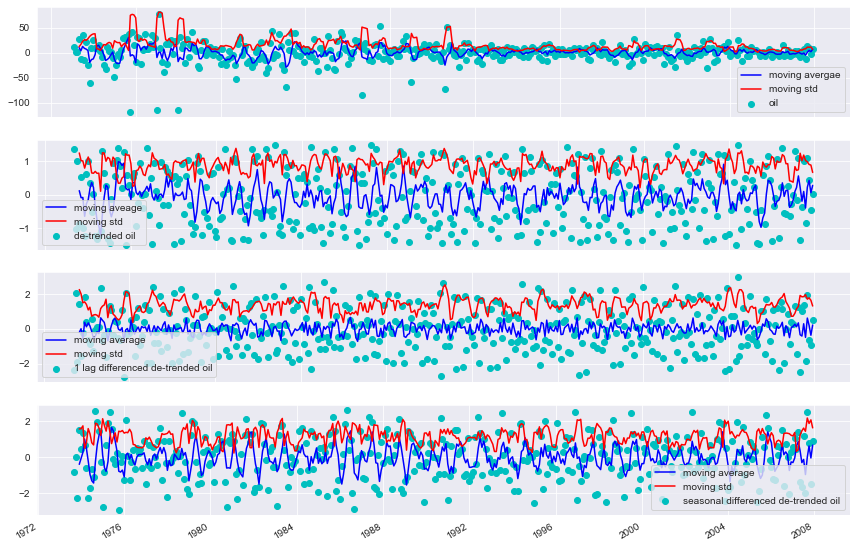

In [12]:
plot_rolling(df1,'oil')

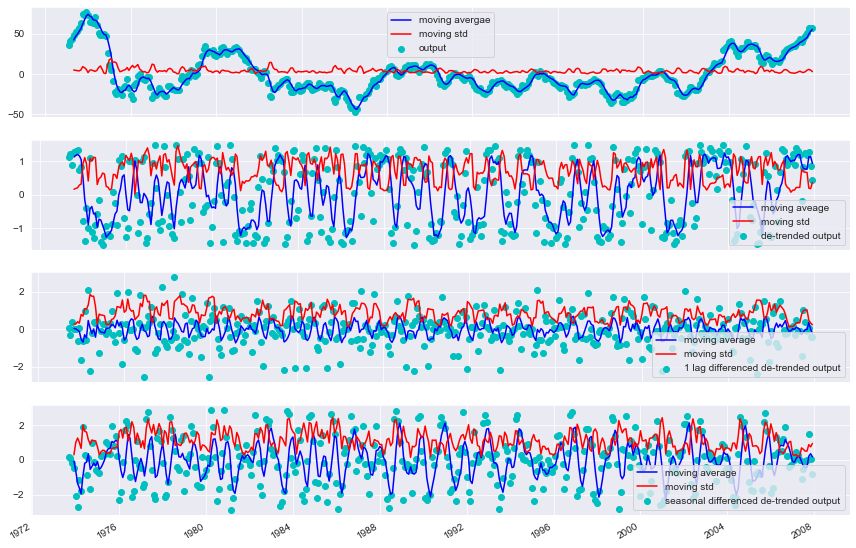

In [13]:
plot_rolling(df2,'output')

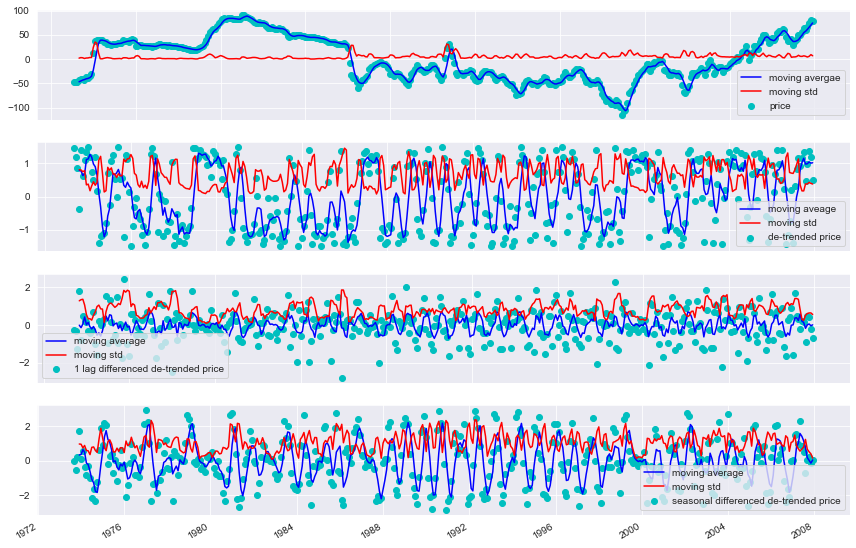

In [14]:
plot_rolling(df3,'price')

### Lets do some adf tests quickly

In [15]:
def adf_test(df,name):
    
    print("-----------------------------------------")
    print("for variable " + name)
    print("-----------------------------------------")
    
    dftest = adfuller(df.data.dropna(), autolag='BIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    print("\n > Is the de-trended data stationary ?")
    dftest = adfuller(df.z_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    print("\n > Is the 1-lag differenced de-trended data stationary ?")
    dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
    print("\n > Is the seasonal differenced de-trended data stationary ?")
    dftest = adfuller(df.zs_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

In [16]:
adf_test(df1,'oil')

-----------------------------------------
for variable oil
-----------------------------------------
Test statistic = -22.347
P-value = 0.000
Critical values :
	1%: -3.4460914174990296 - The data is  stationary with 99% confidence
	5%: -2.868479374038333 - The data is  stationary with 95% confidence
	10%: -2.570466459559076 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -11.883
P-value = 0.000
Critical values :
	1%: -3.4464005219454155 - The data is  stationary with 99% confidence
	5%: -2.868615280538588 - The data is  stationary with 95% confidence
	10%: -2.570538905413444 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -10.368
P-value = 0.000
Critical values :
	1%: -3.446845912589748 - The data is  stationary with 99% confidence
	5%: -2.8688110853002007 - The data is  stationary with 95% confidence
	10%: -2.5706432834592747 - The data is  stationary with 90

In [17]:
adf_test(df2,'output') 

-----------------------------------------
for variable output
-----------------------------------------
Test statistic = -2.567
P-value = 0.100
Critical values :
	1%: -3.446129402876608 - The data is not stationary with 99% confidence
	5%: -2.8684960761128346 - The data is not stationary with 95% confidence
	10%: -2.570475362616382 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -5.960
P-value = 0.000
Critical values :
	1%: -3.4467631030732506 - The data is  stationary with 99% confidence
	5%: -2.868774682311516 - The data is  stationary with 95% confidence
	10%: -2.570623877774392 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -7.484
P-value = 0.000
Critical values :
	1%: -3.446845912589748 - The data is  stationary with 99% confidence
	5%: -2.8688110853002007 - The data is  stationary with 95% confidence
	10%: -2.5706432834592747 - The data is  stationar

In [18]:
adf_test(df3,'price')

-----------------------------------------
for variable price
-----------------------------------------
Test statistic = -2.269
P-value = 0.182
Critical values :
	1%: -3.446129402876608 - The data is not stationary with 99% confidence
	5%: -2.8684960761128346 - The data is not stationary with 95% confidence
	10%: -2.570475362616382 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -5.607
P-value = 0.000
Critical values :
	1%: -3.4466811208382437 - The data is  stationary with 99% confidence
	5%: -2.8687386420385494 - The data is  stationary with 95% confidence
	10%: -2.5706046655665635 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -7.685
P-value = 0.000
Critical values :
	1%: -3.4469717056192213 - The data is  stationary with 99% confidence
	5%: -2.868866381945153 - The data is  stationary with 95% confidence
	10%: -2.570672761197837 - The data is  stationar

### We can see that oil is stationary, but price and output are non-stationary

### Thus we have to difference the non-stationary series

In [19]:
df['price']  = df['price'].diff(1)
df['output'] = df['output'].diff(1)

df = df.dropna()

df.head()

,oil,output,price
1973-03-01,1.419150,5.462780,-0.286938
1973-04-01,1.177711,2.464233,1.203972
1973-05-01,27.455135,4.114639,3.224850
1973-06-01,-13.110436,3.927574,2.286587
1973-07-01,36.258072,0.909397,0.583103


In [20]:
df = df.rename(columns={"output" : "D1_output"})
df = df.rename(columns={"price"  : "D1_price"})

df.head()

,oil,D1_output,D1_price
1973-03-01,1.419150,5.462780,-0.286938
1973-04-01,1.177711,2.464233,1.203972
1973-05-01,27.455135,4.114639,3.224850
1973-06-01,-13.110436,3.927574,2.286587
1973-07-01,36.258072,0.909397,0.583103


### We will use BIC when selecting the order of var

### The following function, 

#### training the VAR model
#### report the training result
#### plot the input processes
#### plot the acf
#### plot the irf
#### plot cumulative effects
#### do Granger tests
#### compute Ljung-Box test

#### You only need to input the dataframe "df" and set the lag number "i"

In [21]:
def var_est(df,i):
    
    print("---------------------------------------------")
    print("VAR result for max lag = " + str(i))
    print("---------------------------------------------")
    
    model  = VAR(df)
    result = model.fit(i, trend='c')
    
    print(result.summary())
    
    print("---------------------------------------------")
    print("Plotting input time series")
    print("---------------------------------------------")
    
    result.plot()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting time series autocorrelation function")
    print("---------------------------------------------")
          
    result.plot_acorr()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting IRF")
    print("---------------------------------------------")
    
    irf = result.irf(10)
    irf.plot(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting cumulative effects")
    print("---------------------------------------------")
    
    irf.plot_cum_effects(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Granger test")
    print("---------------------------------------------")
    
    test_result1 = result.test_causality('oil', ['D1_output', 'D1_price'], kind='f')
    print(test_result1.summary())
    
    test_result2 = result.test_causality('D1_price', ['oil', 'D1_output'], kind='f')
    print(test_result2.summary())
    
    test_result3 = result.test_causality('D1_output', ['D1_price', 'oil'], kind='f')
    print(test_result3.summary())
    
    print("---------------------------------------------")
    print("Ljung-Box test for VAR")
    print("---------------------------------------------")
    test_result4 = result.test_whiteness()
    print(test_result4.summary())

---------------------------------------------
VAR result for max lag = 1
---------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Oct, 2022
Time:                     14:52:08
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    12.9267
Nobs:                     417.000    HQIC:                   12.8565
Log likelihood:          -4434.11    FPE:                    366084.
AIC:                      12.8106    Det(Omega_mle):         355748.
--------------------------------------------------------------------
Results for equation oil
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.927990         1.006497            0.922           0.357
L1.oil              -0.0960

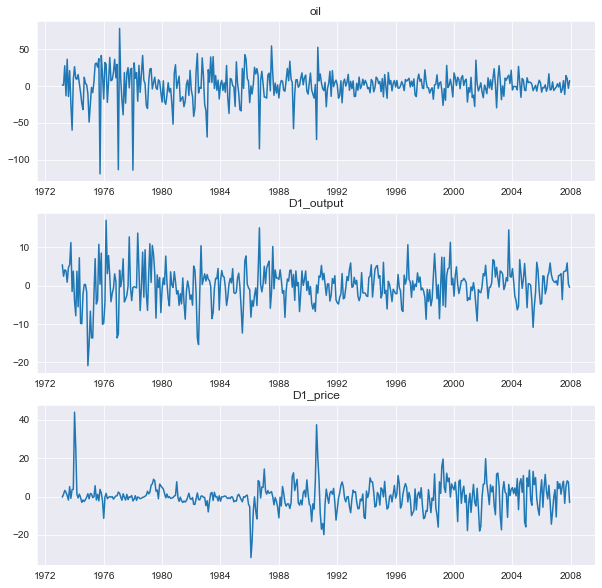

---------------------------------------------
Plotting time series autocorrelation function
---------------------------------------------


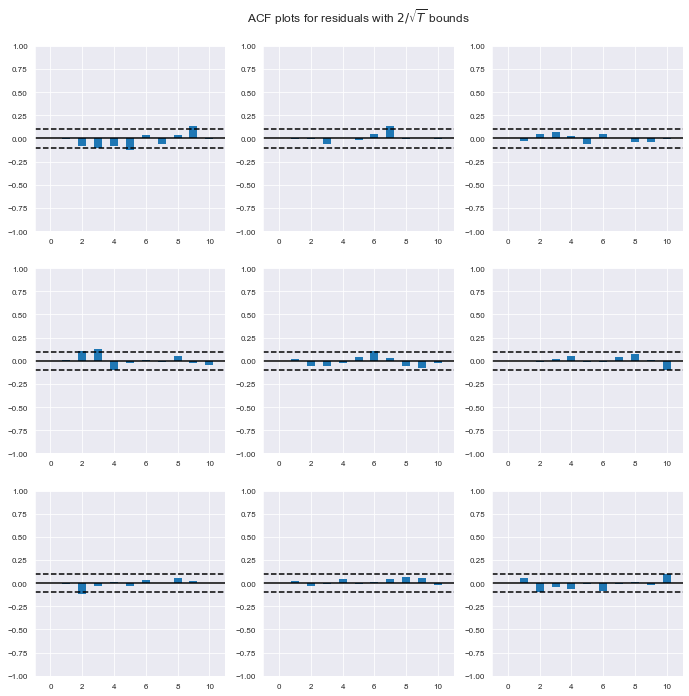

---------------------------------------------
Plotting IRF
---------------------------------------------


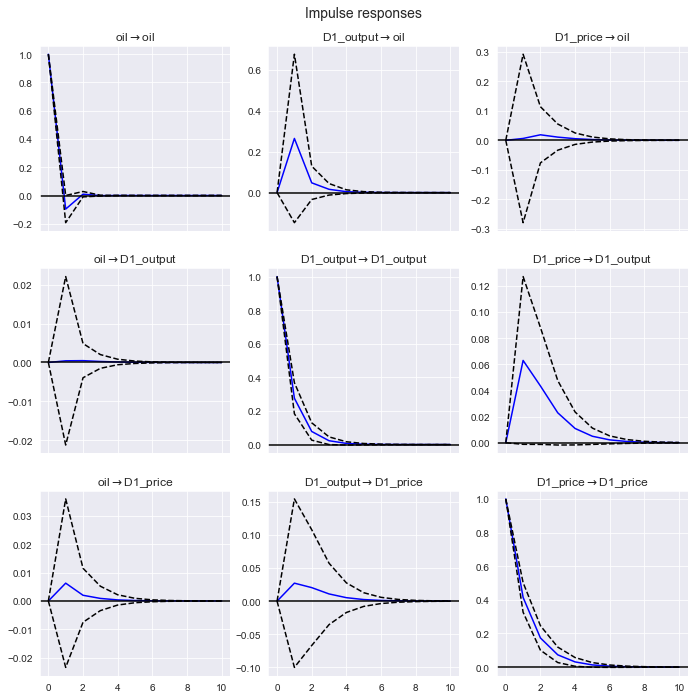

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


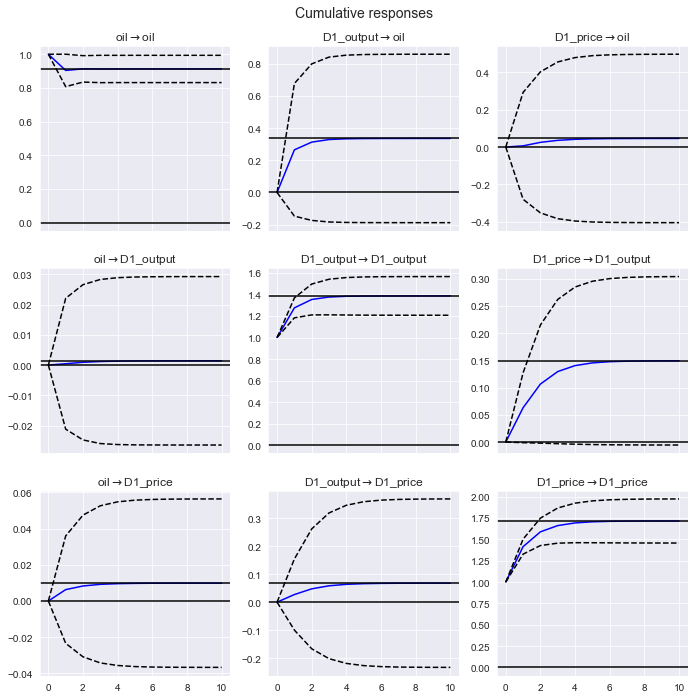

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['D1_output', 'D1_price'] do not Granger-cause oil. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.8049          3.003   0.447 (2, 1239)
-----------------------------------------------
Granger causality F-test. H_0: ['oil', 'D1_output'] do not Granger-cause D1_price. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.1896          3.003   0.827 (2, 1239)
-----------------------------------------------
Granger causality F-test. H_0: ['D1_price', 'oil'] do not Granger-cause D1_output. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-------------------------------------------

In [22]:
var_est(df,1)

### Now let's write a function to select the lag number and do all the things above.

In [23]:
def var_est_BIC(df,i):
    
    print("---------------------------------------------")
    print("VAR result for lag = " + str(i))
    print("---------------------------------------------")
    
    model  = VAR(df)
    result = model.fit(maxlags=i, ic='bic', trend='c',verbose=True)
    
    print(result.summary())
    
    print("---------------------------------------------")
    print("Plotting input time series")
    print("---------------------------------------------")
    
    result.plot()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting time series autocorrelation function")
    print("---------------------------------------------")
          
    result.plot_acorr()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting IRF")
    print("---------------------------------------------")
    
    irf = result.irf(10)
    irf.plot(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting cumulative effects")
    print("---------------------------------------------")
    
    irf.plot_cum_effects(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Granger test")
    print("---------------------------------------------")
    
    test_result1 = result.test_causality('oil', ['D1_output', 'D1_price'], kind='f')
    print(test_result1.summary())
    
    test_result2 = result.test_causality('D1_price', ['oil', 'D1_output'], kind='f')
    print(test_result2.summary())
    
    test_result3 = result.test_causality('D1_output', ['D1_price', 'oil'], kind='f')
    print(test_result3.summary())
    
    print("---------------------------------------------")
    print("Ljung-Box test for VAR")
    print("---------------------------------------------")
    test_result4 = result.test_whiteness()
    print(test_result4.summary())

In [24]:
### let's do the selection and training on "df" with max lag number = 5
### apparently, BIC choose p = 1

---------------------------------------------
VAR result for lag = 5
---------------------------------------------
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 3, BIC -> 1, FPE -> 3, HQIC ->  1>
Using 1 based on bic criterion
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Oct, 2022
Time:                     14:52:12
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    12.9267
Nobs:                     417.000    HQIC:                   12.8565
Log likelihood:          -4434.11    FPE:                    366084.
AIC:                      12.8106    Det(Omega_mle):         355748.
--------------------------------------------------------------------
Results for equation oil
                  coefficient       std. error           t-stat            prob
------------------------------------

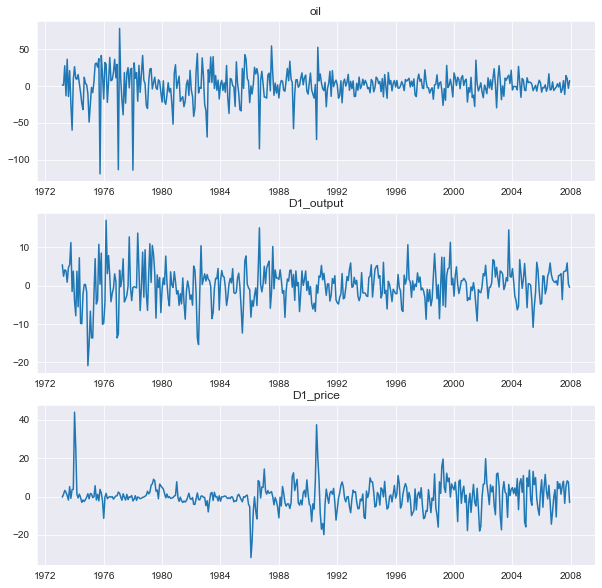

---------------------------------------------
Plotting time series autocorrelation function
---------------------------------------------


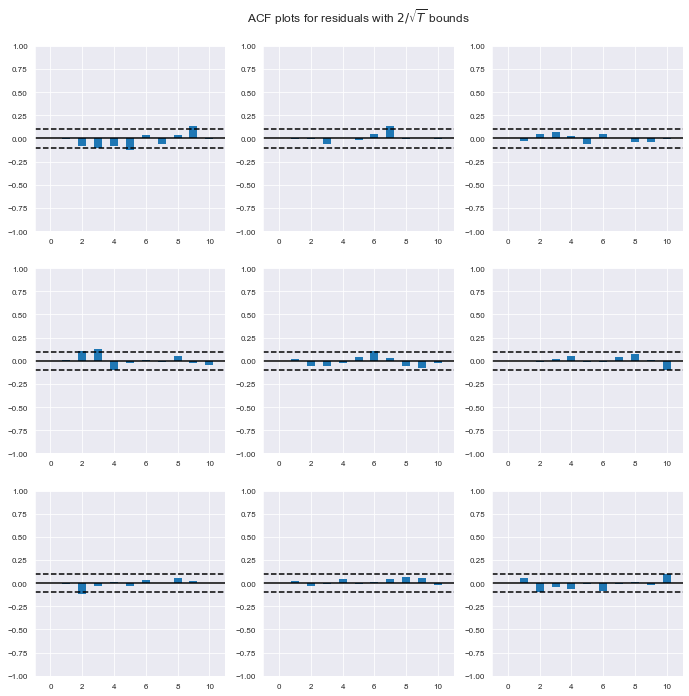

---------------------------------------------
Plotting IRF
---------------------------------------------


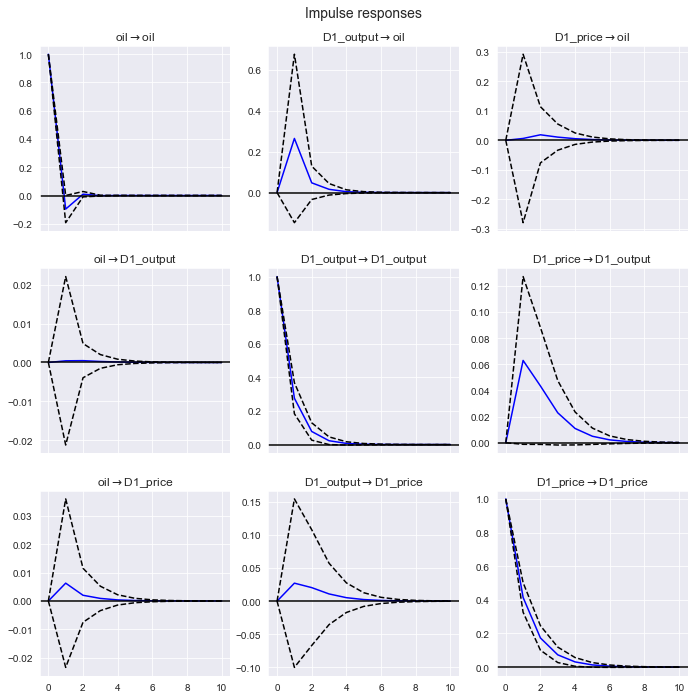

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


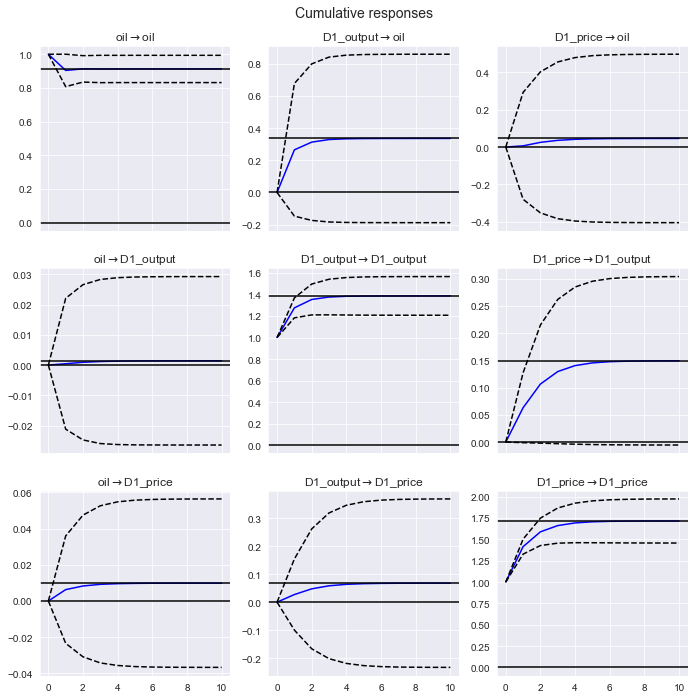

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['D1_output', 'D1_price'] do not Granger-cause oil. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.8049          3.003   0.447 (2, 1239)
-----------------------------------------------
Granger causality F-test. H_0: ['oil', 'D1_output'] do not Granger-cause D1_price. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.1896          3.003   0.827 (2, 1239)
-----------------------------------------------
Granger causality F-test. H_0: ['D1_price', 'oil'] do not Granger-cause D1_output. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-------------------------------------------

In [25]:
var_est_BIC(df,5)

### now let's focus on the VAR result (selected by BIC)

In [26]:
model  = VAR(df)
result = model.fit(1, trend='c')

In [27]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Oct, 2022
Time:                     14:52:16
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    12.9267
Nobs:                     417.000    HQIC:                   12.8565
Log likelihood:          -4434.11    FPE:                    366084.
AIC:                      12.8106    Det(Omega_mle):         355748.
--------------------------------------------------------------------
Results for equation oil
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.927990         1.006497            0.922           0.357
L1.oil              -0.096006         0.049105           -1.955           0.051
L1.D1_output         0.264808         0.210096            1.260   

### Now lets check the eigenvalues of the companion coefficients matrix for the above VAR model

In [28]:
result.is_stable(verbose =1 )

Eigenvalues of VAR(1) rep
0.09583751397098023
0.42710897123438263
0.26290966237961927


True

### Note that all eigen vlaues are real and less than 1 in modulus. This all are within the unit circle and hence are stationary

### Lets also check the residuals of the portmanteau / Ljung-Box test

### The p value rejects H_0 such that there is no autocorrelation at the lag order p=1

### This means the model is to simple and doesn't extract all the useful patterns from the data 

In [29]:
test_result = result.test_whiteness(nlags = 10, signif = 0.05)
print(test_result.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         112.9          103.0   0.011 81
----------------------------------------


### Now lets compute the coefficient matrices of the MA representation

In [30]:
result.ma_rep()

array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       [[-9.60061720e-02,  2.64808179e-01,  6.30267242e-03],
        [ 4.32384382e-04,  2.75774937e-01,  6.29438708e-02],
        [ 6.28522007e-03,  2.71159618e-02,  4.14412354e-01]],

       [[ 9.37129767e-03,  4.77751424e-02,  1.86748617e-02],
        [ 4.73345287e-04,  7.78730986e-02,  4.34457849e-02],
        [ 2.01297745e-03,  2.03794699e-02,  1.73483997e-01]],

       [[-7.61669576e-04,  1.61631700e-02,  1.08053100e-02],
        [ 2.61293362e-04,  2.27788688e-02,  2.29090876e-02],
        [ 9.05938603e-04,  1.08573854e-02,  7.31893614e-02]],

       [[ 1.48027434e-04,  4.54869724e-03,  5.49042589e-03],
        [ 1.28752109e-04,  6.97223569e-03,  1.09292460e-02],
        [ 3.77730109e-04,  5.21869465e-03,  3.10196912e-02]],

       [[ 2.22637733e-05,  1.44249375e-03,  2.56254590e-03],
        [ 5.93

### Now we compute the ARDL of each VAR Equation (p=2)

### Note that this MLE is different to estimating by OLS (R uses OLS)

In [31]:
ardl_model = ARDL(df['D1_price'], 0, df[["oil", "D1_output"]], 1)
ardl_result = ardl_model.fit()

In [32]:
ardl_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:               D1_price   No. Observations:                  418
Model:                  ARDL(0, 1, 1)   Log Likelihood               -1399.831
Method:               Conditional MLE   S.D. of innovations              6.889
Date:                Tue, 18 Oct 2022   AIC                           2811.662
Time:                        14:52:16   BIC                           2835.875
Sample:                    04-01-1973   HQIC                          2821.234
                         - 12-01-2007                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3060      0.340      0.899      0.369      -0.363       0.975
oil.L0          -0.0113      0.017     -0.679      0.497      -0.044       0.021
oil.L1           0.0007      0.017      0.042      0.966      -0.032       0.033
D1_output.L0     0.1031      0.074      1.394      0.164      -0.042       0.248
D1_output.L1     0.0490      0.074      0.664      0.507      -0.096       0.194
================================================================================
"""

### Lets use OLS as a comparison

In [33]:
df['L1_oil'] = df['oil'].shift(1)
df['L2_oil'] = df['oil'].shift(2)

df['L1_output'] = df['D1_output'].shift(1)
df['L2_output'] = df['D1_output'].shift(2)

df['L1_price'] = df['D1_price'].shift(1)
df['L2_price'] = df['D1_price'].shift(2)

df = df.drop(['D1_output','oil'], axis=1)

df

,D1_price,L1_oil,L2_oil,L1_output,L2_output,L1_price,L2_price
1973-03-01,-0.286938,NaN,NaN,NaN,NaN,NaN,NaN
1973-04-01,1.203972,1.419150,NaN,5.462780,NaN,-0.286938,NaN
1973-05-01,3.224850,1.177711,1.419150,2.464233,5.462780,1.203972,-0.286938
1973-06-01,2.286587,27.455135,1.177711,4.114639,2.464233,3.224850,1.203972
1973-07-01,0.583103,-13.110436,27.455135,3.927574,4.114639,2.286587,3.224850
...,...,...,...,...,...,...,...
2007-08-01,-3.530888,7.305458,-4.530017,3.551182,-3.633133,7.996284,5.583969
2007-09-01,5.244854,-11.455108,7.305458,3.800983,3.551182,-3.530888,7.996284
2007-10-01,8.216675,14.142312,-11.455108,3.814732,3.800983,5.244854,-3.530888
2007-11-01,7.532234,10.104911,14.142312,5.937366,3.814732,8.216675,5.244854


In [34]:
df = df.dropna()

Y = df['D1_price']
X = sm.add_constant(df.drop(['D1_price'], axis=1))

In [35]:
mod = sm.OLS(Y,X)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               D1_price   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     16.93
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           1.75e-17
Time:                        14:52:17   Log-Likelihood:                -1349.7
No. Observations:                 416   AIC:                             2713.
Df Residuals:                     409   BIC:                             2742.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2199      0.308      0.714      0.4